In [10]:
import pandas as pd
import numpy as np
from datetime import timedelta
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## Download relevant data

In [2]:
RE_DOWNLOAD_PRICES = False
def download_prices(ticker:str, price_ref:str='Adj Close',start:str=None, end:str=None, period:str=None):
    df = yf.download(ticker, start, end, period)
    df = df[[price_ref]]
    df = df.rename(columns={
        price_ref: 'price'
    })
    return df
if RE_DOWNLOAD_PRICES:
    df_sp500 = download_prices('^GSPC')
    df_vix = download_prices('^VIX')

In [3]:
if RE_DOWNLOAD_PRICES:
    print(df_sp500.head())
    print(df_vix.head())

In [4]:
if RE_DOWNLOAD_PRICES:
    df_sp500.to_csv('prices_sp500.csv')
    df_vix.to_csv('prices_vix.csv')

## Volatility Calculations

### Individual stock volatility

In [5]:
YEAR = 252
def calc_rolling_vol(df:pd.DataFrame, period_days:int=6*30, calc:str='std'):
    """
    df: Price pd.DataFrame. Index must be datetime series
    period_days: Number of days for calculation. Default 6*30
    calc: What calculation to perform. Default 'std'
    scale_by_price: Whether to calculate the percentagewise calculation (divided by price)
    """
    df_rets = df.pct_change()
    df_vol = df_rets.rolling(window=f'{period_days}D').agg(calc)
    df_vol = df_vol[df_vol.index >= df_vol.index[0] + timedelta(days=period_days)]
    df_vol = df_vol.dropna()
    return df_vol

In [6]:
UNIVERSE = 'spx'
df = pd.read_parquet(f'Pairs_SP500_FPT/{UNIVERSE}_impl_vols.parquet')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df[df['Date']>='2003-01-01']
df = df[~df['p_price'].isna()]
df['Id'] = df['Id'].str.replace('-', '_')
df = df.pivot(index='Date', columns='Id', values='p_price')
df = df.sort_index()
df = df.dropna(axis=1)
df.head()

Id,AAPL_US,AAP_US,ABC_US,ABT_US,ACGL_US,ACN_US,ADBE_US,ADI_US,ADM_US,ADP_US,...,WTW_US,WYNN_US,WY_US,XEL_US,XOM_US,XRAY_US,YUM_US,ZBH_US,ZBRA_US,ZION_US
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-02,0.264286,16.613333,14.4075,40.05,3.447667,18.61,12.800,25.90,12.52,40.62,...,76.953445,13.500,20.152962,11.35,35.47,18.740,12.560,40.30,26.092888,40.642
2003-01-03,0.266071,16.356667,14.6250,40.44,3.458889,18.75,13.150,26.01,12.60,40.39,...,76.185240,13.400,20.038456,11.54,35.50,18.650,12.275,40.40,26.444445,40.270
2003-01-06,0.266071,15.313333,14.8000,40.70,3.425556,19.10,13.755,27.61,12.62,40.50,...,77.218346,13.290,20.571497,12.25,36.38,18.705,12.495,40.66,26.760445,41.390
2003-01-07,0.265179,15.400001,14.4200,38.87,3.378889,18.73,14.255,27.74,12.44,40.12,...,76.317690,13.310,20.528065,11.80,35.15,18.105,12.575,40.26,26.377777,41.590
2003-01-08,0.259821,15.303333,13.8925,39.85,3.331111,18.60,13.565,27.01,12.35,39.78,...,75.072655,13.029,20.105580,12.60,35.00,17.920,12.635,40.00,25.475555,42.030


In [7]:
df_vol = calc_rolling_vol(df, period_days=6*30, calc='std')
df_vol = df_vol*100*((YEAR)**.5)
df_vol.to_csv('Pairs_SP500_FPT/6mo_rolling_vol.csv')
df_vol.head()

Id,AAPL_US,AAP_US,ABC_US,ABT_US,ACGL_US,ACN_US,ADBE_US,ADI_US,ADM_US,ADP_US,...,WTW_US,WYNN_US,WY_US,XEL_US,XOM_US,XRAY_US,YUM_US,ZBH_US,ZBRA_US,ZION_US
Date,,,,,,,,,,,,,,,,,,,,,
2003-07-01,37.218094,33.527029,31.927592,27.429744,23.454067,44.213714,45.183208,50.279124,23.597054,32.491510,...,28.012196,32.284451,26.165981,30.352586,20.161171,26.395151,30.584501,31.403049,25.878561,23.004271
2003-07-02,37.226563,33.437753,31.934010,27.469478,23.465593,44.217046,45.139793,50.313992,23.583080,32.641698,...,27.976201,32.261964,26.312610,30.282921,20.164206,26.386726,30.404150,31.402994,26.263277,23.016605
2003-07-03,37.101256,33.372391,31.806951,27.358491,23.372336,44.107594,44.965375,50.111466,23.506046,32.533666,...,27.984109,32.263525,26.255964,30.222474,20.102767,26.280425,30.298301,31.340154,26.183193,22.928436
2003-07-07,37.610107,32.254675,31.544461,26.642510,23.388300,44.301894,44.132520,49.694927,23.916020,32.942781,...,28.015904,32.321785,26.121366,27.098391,19.337151,26.409407,30.506074,31.550133,25.712546,22.875979
2003-07-08,37.755185,32.517337,31.569864,26.694015,23.350769,45.595992,43.789224,49.273440,23.904145,32.885544,...,27.895948,32.436129,26.166143,27.012369,19.169726,26.236869,30.502324,31.542993,25.773860,22.761054


### SP500 volatiltiy vs VIX

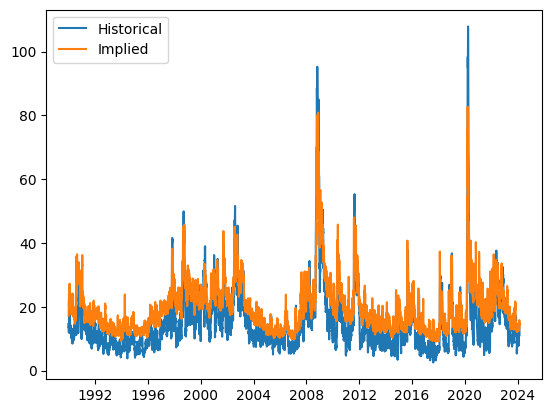

In [13]:
df_sp = pd.read_csv('prices_sp500.csv', index_col=0, parse_dates=True)
df_sp_vol = calc_rolling_vol(df_sp, period_days=YEAR//12)
df_vix = pd.read_csv('prices_vix.csv', index_col=0, parse_dates=True)
df_sp_vol = df_sp_vol[df_sp_vol.index.isin(set(df_vix.index))]
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=df_sp_vol.index, y=df_sp_vol['price']*100*(YEAR**.5), mode='lines', name='SP500'))
# fig.add_trace(go.Scatter(x=df_vix.index, y=df_vix['price'], mode='lines', name='VIX'))
# fig.show()
plt.plot(df_sp_vol.index,df_sp_vol['price']*100*(YEAR**.5))
plt.plot(df_vix.index,df_vix['price'])
plt.legend(['Historical', 'Implied'])


In [9]:
vol_spread = df_vix - df_sp_vol*100*(YEAR**.5)
vol_spread = vol_spread.rename(columns={
    'price': 'vol_spread'
})
vol_spread.to_csv('Pairs_SP500_FPT/spx_impl_minus_hist_vol.csv')

### Implied volatility - Historical volatility

In [10]:
UNIVERSE = 'spx'
df_histvol = pd.read_parquet(f'Pairs_SP500_FPT/{UNIVERSE}_impl_vols.parquet')
df_histvol['Date'] = pd.to_datetime(df_histvol['Date'], format='%Y-%m-%d')
df_histvol = df_histvol[df_histvol['Date']>='2003-01-01']
df_histvol = df_histvol[~df_histvol['p_price'].isna()]
df_histvol['Id'] = df_histvol['Id'].str.replace('-', '_')
df_histvol = df_histvol.pivot(index='Date', columns='Id', values='p_price')
df_histvol = df_histvol.sort_index()
df_histvol = df_histvol.dropna(axis=1)
df_histvol = calc_rolling_vol(df_histvol, period_days=YEAR//12, calc='std')
df_histvol = df_histvol*100*((YEAR)**.5)

df = pd.read_parquet(f'Pairs_SP500_FPT/spx_impl_vols.parquet')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df[df['Date']>='2003-01-01']
df = df[~df['p_price'].isna()]
df['Id'] = df['Id'].str.replace('-', '_')
df = df[df['Date'] >= df_histvol.index[0]]
df[df['p_opt_atmiv_mkt'].isna()]["Id"].value_counts()
df['p_opt_atmiv_mkt'] = df['p_opt_atmiv_mkt'].interpolate()
df_implvol = df.pivot(index='Date', columns='Id', values='p_opt_atmiv_mkt')
df_implvol = df_implvol.sort_index()
df_implvol = df_implvol.dropna(axis=1)

df_impl_hist = df_implvol - df_histvol
df_impl_hist.to_csv('Pairs_SP500_FPT/1mo_rolling_impl_minus_hist_vol.csv')
df_impl_hist.head()

Id,AAPL_US,AAP_US,ABC_US,ABT_US,ACGL_US,ACN_US,ADBE_US,ADI_US,ADM_US,ADP_US,...,WTW_US,WYNN_US,WY_US,XEL_US,XOM_US,XRAY_US,YUM_US,ZBH_US,ZBRA_US,ZION_US
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-23,11.539835,-8.353960,8.330985,14.828356,12.711173,-32.092914,-31.881659,-28.201798,6.465286,-10.111005,...,-3.134395,-2.617345,8.522284,-22.396899,2.422239,3.928446,-3.688830,18.744137,3.919103,1.387715
2003-01-24,10.047818,-8.060849,8.553288,14.193384,12.722383,-31.820730,-33.078396,-28.999965,5.010899,-10.294192,...,-4.379598,-3.658722,3.870948,-22.646792,1.502377,0.947459,-2.173400,18.654038,4.368834,1.292397
2003-01-27,7.072141,2.210023,10.118244,14.539508,13.341034,-30.708732,-28.784508,-21.212834,5.003439,-9.846310,...,-3.370582,-3.262366,4.943841,-16.642648,4.167395,1.502258,-4.077276,17.908501,2.506815,0.591744
2003-01-28,3.167874,-0.089697,8.829546,17.677580,12.591942,-30.965770,-28.370520,-22.127259,5.751468,-12.384630,...,-3.420047,-3.271340,4.792163,-15.897214,2.453938,4.813302,-3.696301,14.292821,1.845435,-1.563766
2003-01-29,2.778012,0.072892,12.875645,19.375270,13.826058,-30.968242,-24.152442,-21.564942,5.790516,-12.548828,...,-3.318693,-2.478538,5.686963,-1.628244,-3.116806,4.858618,-5.420676,9.832914,5.279975,-1.395669


### Volatility minus SP500 volatility

In [9]:
UNIVERSE = 'spx'
df_histvol = pd.read_parquet(f'Pairs_SP500_FPT/{UNIVERSE}_impl_vols.parquet')
df_histvol['Date'] = pd.to_datetime(df_histvol['Date'], format='%Y-%m-%d')
df_histvol = df_histvol[df_histvol['Date']>='2003-01-01']
df_histvol = df_histvol[~df_histvol['p_price'].isna()]
df_histvol['Id'] = df_histvol['Id'].str.replace('-', '_')
df_histvol = df_histvol.pivot(index='Date', columns='Id', values='p_price')
df_histvol = df_histvol.sort_index()
df_histvol = df_histvol.dropna(axis=1)
df_histvol = calc_rolling_vol(df_histvol, period_days=YEAR//12, calc='std')
df_histvol = df_histvol*100*((1/(YEAR//12))**.5)

df_sp = pd.read_csv('prices_sp500.csv', index_col=0, parse_dates=True)
df_sp_vol = calc_rolling_vol(df_sp, period_days=YEAR//12)
df_sp_vol = df_sp_vol[df_sp_vol.index.isin(set(df_histvol.index))]*100*((1/(YEAR//12))**.5)
df_hist_minus_sp = pd.DataFrame(df_histvol)
for c in df_hist_minus_sp.columns:
    df_hist_minus_sp[c] = df_hist_minus_sp[c] - df_sp_vol['price']
df_hist_minus_sp.to_csv('Pairs_SP500_FPT/1mo_rolling_hist_stock_minus_sp_vol.csv')
df_hist_minus_sp

Id,AAPL_US,AAP_US,ABC_US,ABT_US,ACGL_US,ACN_US,ADBE_US,ADI_US,ADM_US,ADP_US,...,WTW_US,WYNN_US,WY_US,XEL_US,XOM_US,XRAY_US,YUM_US,ZBH_US,ZBRA_US,ZION_US
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-23,0.039322,0.220554,0.073998,0.191724,-0.029673,0.564146,0.470344,0.503317,-0.003453,0.202416,...,0.163120,0.134027,0.086240,0.401262,0.076908,-0.000055,0.089455,0.049784,0.067132,-0.000160
2003-01-24,0.016141,0.175995,0.035204,0.156038,-0.073877,0.516507,0.443201,0.470435,-0.027308,0.160957,...,0.136255,0.104739,0.106110,0.360691,0.045606,0.001039,0.024479,0.006825,0.017143,-0.042731
2003-01-27,0.096772,0.077694,0.061369,0.190281,-0.043017,0.540740,0.423997,0.402952,0.012363,0.194239,...,0.161819,0.139103,0.130708,0.317565,0.048439,0.036944,0.089923,0.056292,0.082348,0.006434
2003-01-28,0.127973,0.090000,0.064567,0.123950,-0.055548,0.521598,0.395934,0.392890,-0.020546,0.206377,...,0.139738,0.116845,0.109946,0.284534,0.049267,-0.027233,0.061764,0.083019,0.068854,0.013404
2003-01-29,0.131769,0.089362,0.015336,0.098325,-0.074437,0.519862,0.336483,0.383433,-0.022804,0.206784,...,0.136490,0.104471,0.095703,0.086507,0.124024,-0.025613,0.083451,0.142257,0.019962,0.009339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-26,0.022596,0.300713,-0.002193,0.029348,0.222055,0.126439,0.433879,0.418505,0.177302,0.073040,...,0.081152,0.420462,0.062608,-0.012080,0.133187,0.092411,0.073130,0.079504,0.295521,0.783884
2023-05-30,0.022156,0.296161,0.021757,0.036989,0.208283,0.110676,0.427080,0.417936,0.198012,0.085449,...,0.083832,0.423767,0.075195,-0.008823,0.140979,0.097066,0.077561,0.085713,0.278510,0.815702
2023-05-31,0.010676,1.879097,0.068046,0.030410,0.204893,0.121724,0.424349,0.409683,0.196012,0.077270,...,0.084396,0.417881,0.068482,0.033693,0.143535,0.083292,0.081229,0.075066,0.285183,0.867142
